In [8]:
# Esse programa serve para fazer o scraping de dados de organismos celulares do site https://www.ncbi.nlm.nih.gov/Taxonomy/Browser/wwwtax.cgi
# Autor: Deivis Felipe Guerreiro Fagundes
# Data: 21/05/2023

In [9]:
# Faz o import das bibliotecas
# Selenium é uma biblioteca para fazer o scraping de dados
# Pandas é uma biblioteca para manipular os dados
# Time é uma biblioteca para fazer o programa esperar um tempo
# BeautifulSoup é uma biblioteca para fazer o scraping de dados
# OWLReady2 é uma biblioteca para criar ontologias em OWL
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
import pandas as pd
import time
from bs4 import BeautifulSoup
import os
# biblioteca para criar ontologias usando rdflib
from rdflib import Graph, Literal, RDF, URIRef, Namespace


In [10]:
# Captura a pagina html do site
driver_path = './chromedriver.exe'

service = Service(driver_path)

# inicializa o driver do Selenium que esta dentro da pasta
driver = webdriver.Chrome(service=service)

# acessa o site que contem os dados
driver.get('https://www.ncbi.nlm.nih.gov/Taxonomy/Browser/wwwtax.cgi?mode=Tree&id=131567&lvl=4&keep=1&srchmode=1&unlock')


# espera 5 segundos para carregar a pagina
time.sleep(5)

# pega o html da pagina
html = driver.page_source

# fecha o driver
driver.close()



In [11]:
# Faz o scraping dos dados
# cria uma strutura de dados onde cada item pode ter um nome, um link e uma lista de filhos, ou ser uma instancia
class Item:
    def __init__(self, name, link, children, isInstance):
        self.name = name
        self.link = link
        self.children = children
        self.isInstance = isInstance

    # retorna uma string com os dados do item
    def __str__(self):
        return f'Item: {self.name}, Link: {self.link}, isInstance: {self.isInstance}'

# cria uma lista de itens
items = []

quantidade = 0

# Pega o primeiro UL dentro da tag form
ul = BeautifulSoup(html, 'html.parser').find('form').find('ul')

def CriaItem(li, parent):
    # atualiza a quantidade de itens
    global quantidade
    quantidade += 1

    # pega o nome do item
    name = li.find('a').text

    # pega o link do item
    link = li.find('a')['href']

    # pega os filhos do item
    children = []

    # verifica se o item é uma instancia
    isInstance = False

    # verifica se o item é um instancia, se o tipo do li for 'square', então é uma instancia
    if li['type'] == 'square':
        isInstance = True

    # cria um item com os dados
    item = Item(name, link, children, isInstance)

    # verifica se o item tem um pai
    if parent != None:
        # adiciona o item na lista de filhos do pai
        parent.children.append(item)
    else :
        # adiciona o item na lista de itens
        items.append(item)

    # verifica se o item tem filhos
    if li.find('ul') != None:

        # pega o primeiro UL dentro da tag form
        ul = li.find('ul')

        # pega todos os LI dentro do UL, só filhos diretos
        lis = ul.find_all('li', recursive=False)

        # para cada LI dentro do UL
        for li in lis:

            # chama a função novamente
            CriaItem(li, item)

# para cada LI dentro do UL
for li in ul.find_all('li', recursive=False):
    # chama a função para criar o item
    CriaItem(li, None)

In [12]:
# Printa os itens como se fosse uma arvore
def PrintaItens(item, level):
    # printa o nome do item
    print(f'{" " * level}{item.name}')

    # verifica se o item tem filhos
    if len(item.children) > 0:
        # para cada filho do item
        for child in item.children:
            # chama a função novamente
            PrintaItens(child, level + 1)

# printa só o primeiro ramo da arvore
PrintaItens(items[0], 0)

cellular organisms
 Archaea
  Asgard group
   Candidatus Baldrarchaeota
    Candidatus Baldrarchaeia
    unclassified Candidatus Baldrarchaeota
   Candidatus Borrarchaeota
    Candidatus Borrarchaeia
    unclassified Candidatus Borrarchaeota
   Candidatus Freyarchaeota
    Candidatus Freyrarchaeia
    unclassified Candidatus Freyarchaeota
   Candidatus Friggarchaeota
   Candidatus Gefionarchaeota
   Candidatus Gerdarchaeota
    unclassified Candidatus Gerdarchaeota
   Candidatus Heimdallarchaeota
    Candidatus Heimdallarchaeota archaeon
    Candidatus Heimdallarchaeota archaeon AB_125
    Candidatus Heimdallarchaeota archaeon B3_Heim
    Candidatus Heimdallarchaeota archaeon CR_11
    Candidatus Heimdallarchaeota archaeon LC_2
    Candidatus Heimdallarchaeota archaeon LC_3
    Candidatus Heimdallarchaeota archaeon PM71
    Candidatus Heimdallarchaeota archaeon PR6
   Candidatus Helarchaeota
    Candidatus Helarchaeota archaeon
    Candidatus Helarchaeota ASGARD archaeon Hel_GB_A
    C

67541


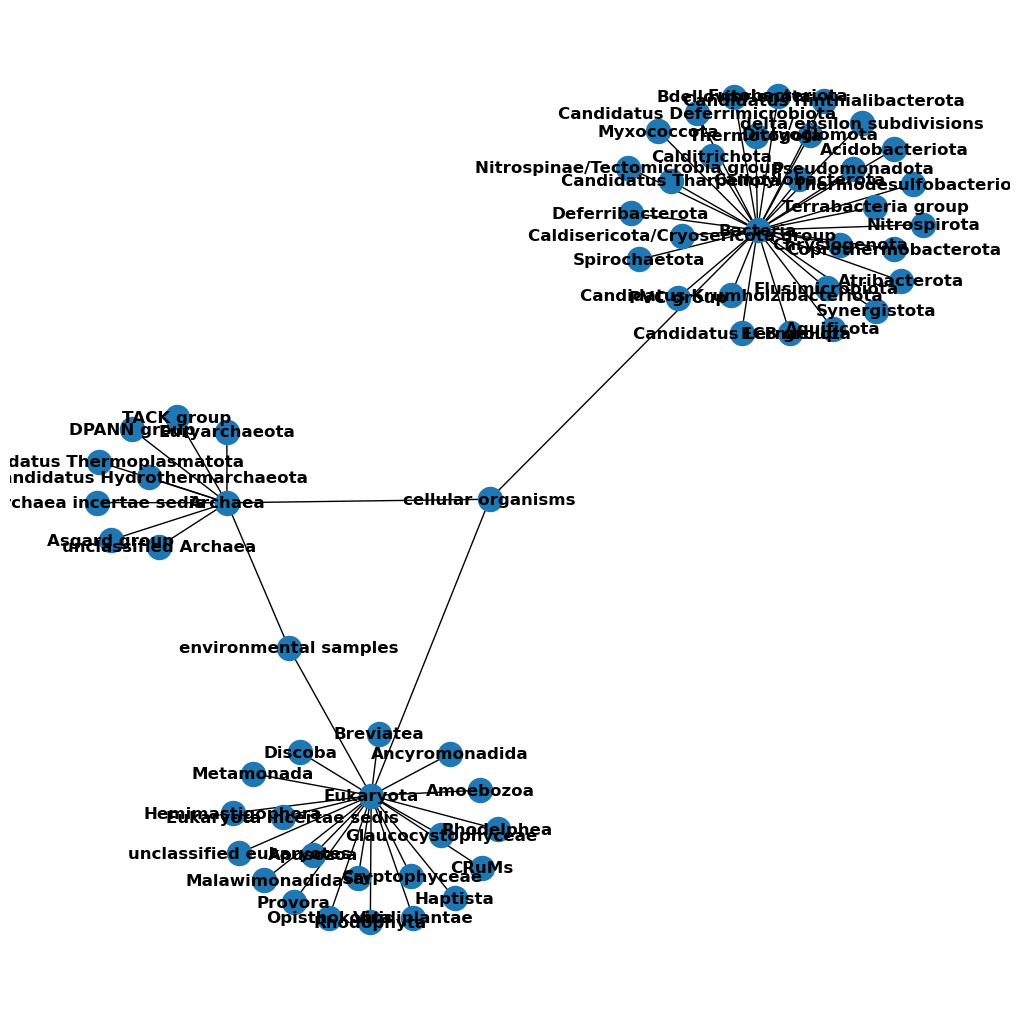

In [13]:
# Printa os itens como se fosse uma arvore usando uma biblioteca grafica
# importa a biblioteca grafica
import networkx as nx
import matplotlib.pyplot as plt

# cria um grafo
G = nx.Graph()

print(quantidade)

# Cria uma função para adicionar itens no grafo recursivamente e recebe um nivel maximo
def AdicionaItens(item, level, maxLevel, quantidadeDeFilhos):
    global G
    # verifica se o nivel é menor que o nivel maximo
    if level < maxLevel:
        # verifica se o item tem filhos
        if len(item.children) > 0:
            filhosIterados = 0
            # para cada filho do item
            for child in item.children:
                # verifica se o filho ja foi iterado
                if filhosIterados >= quantidadeDeFilhos:
                    break

                filhosIterados += 1

                # adiciona o filho no grafo
                G.add_node(child.name)

                # adiciona uma aresta entre o item e o filho
                G.add_edge(item.name, child.name)

                # chama a função novamente
                AdicionaItens(child, level + 1, maxLevel, quantidadeDeFilhos)
            

AdicionaItens(items[0], 0, 2, 30)

# Aumenta o tamanho do grafo
plt.figure(figsize=(10, 10))

# desenha o grafo que aceita muitos itens e niveis
nx.draw(G, with_labels=True, font_weight='bold')

# mostra o grafo
plt.show()

In [14]:
# Insere os dados na ontologia

# Verifica se o arquivo da ontologia existe, se existir abre ele
if os.path.isfile("ontologia.owl"):
    # abre o arquivo da ontologia
    onto = Graph().parse("ontologia.owl")

onto.namespace_manager.bind("OntologiaVirus", URIRef("http://www.semanticweb.org/deivis/ontologies/2023/5/OntologiaVirus#"))

def SerializaNome(nome):
    # Serializa o nome e tira caracteres especiais
    return nome.replace(" ", "_").replace("^", "_").replace("(", "").replace(")", "").replace("/", "").replace("-", "").replace("'", "").replace(".", "").replace(",", "").replace(":", "").replace(";", "").replace("?", "").replace("!", "").replace(">", "").replace("<", "").replace("=", "").replace("+", "").replace("*", "").replace("&", "").replace("%", "").replace("$", "").replace("#", "").replace("@", "")
    
# Percorre os itens recursivamente se não for instancia é uma classe, se for é um individuo, usa hierarquia de classes
def PercorreItens(item, parent):
    # verifica se o item é uma instancia
    if item.isInstance:
        # cria um individuo do item
        individuo = URIRef("http://www.semanticweb.org/deivis/ontologies/2023/5/OntologiaVirus#" + SerializaNome(item.name))
        # adiciona as propriedades do individuo
        onto.add((individuo, URIRef("http://www.w3.org/2000/01/rdf-schema#label"), Literal(item.name)))
        onto.add((individuo, URIRef("http://www.w3.org/2000/01/rdf-schema#comment"), Literal(item.link)))

        # verifica se o item tem um pai
        if parent != "":
            # adiciona o individuo como instancia do pai
            onto.add((individuo, URIRef("http://www.w3.org/1999/02/22-rdf-syntax-ns#type"), parent))

    else:
        # cria uma Entidade classe do item
        classe = URIRef("http://www.semanticweb.org/deivis/ontologies/2023/5/OntologiaVirus#" + SerializaNome(item.name))
        # adiciona a classe na ontologia
        onto.add((classe, RDF.type, URIRef("http://www.w3.org/2002/07/owl#Class")))
        # verifica se o item tem um pai
        if parent != "":
            # adiciona a classe como subclasse do pai
            onto.add((classe, URIRef("http://www.w3.org/2000/01/rdf-schema#subClassOf"), parent))

        # adiciona as propriedades do item
        onto.add((classe, URIRef("http://www.w3.org/2000/01/rdf-schema#label"), Literal(item.name)))
        onto.add((classe, URIRef("http://www.w3.org/2000/01/rdf-schema#comment"), Literal(item.link)))

        # verifica se o item tem filhos
        if len(item.children) > 0:
            # para cada filho do item
            for child in item.children:
                # chama a função novamente
                PercorreItens(child, classe)

# para cada item
for item in items:
    # chama a função para percorrer os itens, pai sendo Thing
    PercorreItens(item, URIRef("http://www.w3.org/2002/07/owl#Thing"))

# salva a ontologia, cria o arquivo
onto.serialize("ontologia.owl", format="xml")

<Graph identifier=N3329707b8af042e7aa2e2d22d5cd9889 (<class 'rdflib.graph.Graph'>)>